# Assignment 1
*by Zeyad Zakaria 6764, Ahmad Hazem 7193 & Nader Mohamed 7115*

## Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip archive.zip -d ORL-dataset

In [3]:
import numpy as np
import pandas as pd
import cv2 as cv
import glob
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.decomposition import PCA, KernelPCA, SparsePCA, IncrementalPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split

## 1. Download the Dataset and Understand the Format (10 Points)
done


## 2. Generate the Data Matrix and the Label vector (10 Points)

In [4]:
N = 10304
D = np.ones((1, N))
y = []

for i in range(1,41):
    for j in range(1,11):
        path=f'drive/MyDrive/Colab-datasets/Assignment1/faces/s{i}/{j}.pgm'
        img = cv.imread(path, 0)
        img = np.reshape(img, (1, N))  
        D = np.vstack((D,img))
        y.append(i)

# skip the first dummy row
D = D [1:]

print("D.shape =",D.shape)

ValueError: ignored

## 3. Split the Dataset into Training and Test sets (10 Points)

### a. From the Data Matrix D 400x10304 keep the odd rows for training and the even rows for testing. This will give you 5 instances per person for training and 5 instances per person for testing.

In [ ]:
d_training = D[0::2, :]
d_testing = D[1::2, :]
print("d_training.shape =",d_training.shape)
print("d_testing.shape =",d_testing.shape)

d_training.shape = (200, 10304)
d_testing.shape = (200, 10304)


### b. Split the labels vector accordingly.

In [ ]:
y_training = y[0::2]
y_testing = y[1::2]

print("y_training.shape =",len(y_training))
print("y_testing.shape =",len(y_testing))

y_training.shape = 200
y_testing.shape = 200


## 4. Classification using PCA (30 points) 

### a. Use the pseudo code below for computing the projection matrix U. 
Define the alpha = {0.8,0.85,0.9,0.95}

In [ ]:
mean = np.mean(d_training,axis=0)

# cenetered data
Z = d_training - mean

cov_matrix = np.cov(Z.T,bias=True)
print(cov_matrix)

# cov_matrix = np.matmul(np.transpose(Z),Z)/(Z.shape[0])
# print(cov_matrix)

print("cov_matrix.shape =",cov_matrix.shape)

[[1241.511775 1237.489525 1220.456225 ...  -69.8075    -99.755425
   -43.884775]
 [1237.489525 1250.244775 1227.058475 ...  -81.5325   -110.499675
   -55.222525]
 [1220.456225 1227.058475 1222.145775 ...  -79.0825   -114.060575
   -67.653225]
 ...
 [ -69.8075    -81.5325    -79.0825   ... 1894.       1865.0575
  1682.5425  ]
 [ -99.755425 -110.499675 -114.060575 ... 1865.0575   1970.238975
  1809.101425]
 [ -43.884775  -55.222525  -67.653225 ... 1682.5425   1809.101425
  1888.737775]]
cov_matrix.shape = (10304, 10304)


In [ ]:
# getting eigen values and vectors
eigen_values,eigen_vectors=np.linalg.eigh(cov_matrix)

In [ ]:
idx = np.argsort(eigen_values)[::-1]
eigen_values = eigen_values[idx]
eigen_vectors = eigen_vectors[:,idx]

### b. Project the training set, and test sets separately using the same projection matrix.

In [ ]:
alphas = [0.8,0.85,0.9,0.95]
#eigen_values[::-1]
proj_matrices = []
sum_eigen_values=np.sum(eigen_values)
print("sum_eigen_values =",sum_eigen_values)
indexes = np.array([])


for alpha in alphas:
    accumulated_eigen_values=0
    explained_variance=0
    idx = 0 
    while explained_variance < alpha:
        accumulated_eigen_values +=eigen_values[idx]
        explained_variance = accumulated_eigen_values/float(sum_eigen_values)
        idx+=1
        #print(explained_variance)
    indexes=np.append(indexes,idx)
print(indexes)


for index in indexes:
     proj_matrix = eigen_vectors[:, :int(index)]
     proj_matrices.append(proj_matrix)



sum_eigen_values = 16008954.48434999
[ 36.  51.  76. 115.]


### c. Use a simple classifier (first Nearest Neighbor to determine the class labels).

In [ ]:
scores = []

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(d_training, y_training)
labels_pred = knn.predict(d_testing)
accuracy = metrics.accuracy_score(y_testing, labels_pred)

print("Accuracy before projection =\n",accuracy)



Accuracy before projection =
 0.94


### d. Report Accuracy for every value of alpha separately.

In [ ]:
for proj_matrix in proj_matrices:
    d_train_pca = np.dot(d_training, proj_matrix)
    d_test_pca = np.dot(d_testing, proj_matrix)
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(d_train_pca, y_training)
    labels_pred = knn.predict(d_test_pca)
    accuracy = metrics.accuracy_score(y_testing, labels_pred)
    scores.append(accuracy)

print("Accuracies after alpha =\n", scores)


Accuracies after alpha =
 [0.95, 0.95, 0.94, 0.94]


### e. Can you find a relation between alpha and classification accuracy?

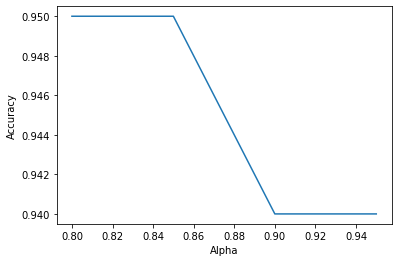

In [ ]:
plt.plot(alphas, scores)
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.show()

## 5. Classification using LDA (30 points) 

### a. Use the pseudo code below for LDA. We will modify few lines in pseudocode to handle multiclass LDA.

#### i. Mean vector for every class

In [ ]:
overall_mean = np.mean(d_training, axis = 0, keepdims=True)
print("overall_mean =\n", overall_mean)
print("overall_mean.shape =", overall_mean.shape,"\n")

print("d_training.shape =",d_training.shape)

# Calculate the mean vector for every class Mu1, Mu2, ..., Mu40.
d_classes = np.array_split(d_training, 40) # to split into 40 persons
d_classes = np.array(d_classes) 
print("d_classes.shape =",d_classes.shape)

mean_classes =  np.mean(d_classes,axis=1)  # to get the mean vector for each class
print("mean_classes.shape =",mean_classes.shape,"\n") 
# print("mean_classes=\n",mean_classes)

m,nk,N = d_classes.shape
print(f'm = {m}, nk = {nk} , N = {N} ')


overall_mean =
 [[86.115 86.265 86.685 ... 76.5   77.395 77.085]]
overall_mean.shape = (1, 10304) 

d_training.shape = (200, 10304)
d_classes.shape = (40, 5, 10304)
mean_classes.shape = (40, 10304) 

m = 40, nk = 5 , N = 10304 


#### ii. Replace B by Sb

In [ ]:
# Sb stands for between-class scatter matrix (B in 2 dimensional sets)
Sb = np.zeros((N,N))

for k in range(0,m):
    # print(mean_classes[k])
    mean_diff = mean_classes[k]-overall_mean
    mean_diff = mean_diff.reshape(N, 1)
    # print("mean_diff =",mean_diff)
    Sb += nk * np.matmul(mean_diff,mean_diff.T)
print("Sb=\n", Sb)
print("Sb.shape =", Sb.shape)

Sb=
 [[221513.555 220621.705 218488.645 ... -16726.5   -21288.885 -10780.955]
 [220621.705 220582.155 218178.495 ... -18392.1   -22588.335 -11850.305]
 [218488.645 218178.495 216305.155 ... -18975.3   -23655.315 -13299.645]
 ...
 [-16726.5   -18392.1   -18975.3   ... 298757.2   305832.7   291714.1  ]
 [-21288.885 -22588.335 -23655.315 ... 305832.7   318949.395 305942.485]
 [-10780.955 -11850.305 -13299.645 ... 291714.1   305942.485 300057.155]]
Sb.shape = (10304, 10304)


#### iii. S matrix remains the same, but it sums S1, S2, S3, ...S40.

In [ ]:
S=np.zeros((N,N))
for k in range(0,m):
    # center class matrices
    Z = d_classes[k]-mean_classes[k]
    S += np.matmul(Z.T,Z)
print("S=\n",S)
print("S.shape =",S.shape)

S=
 [[26788.8 26876.2 25602.6 ...  2765.   1337.8  2004. ]
 [26876.2 29466.8 27233.2 ...  2085.6   488.4   805.8]
 [25602.6 27233.2 28124.  ...  3158.8   843.2  -231. ]
 ...
 [ 2765.   2085.6  3158.8 ... 80042.8 67178.8 44794.4]
 [ 1337.8   488.4   843.2 ... 67178.8 75098.4 55877.8]
 [ 2004.    805.8  -231.  ... 44794.4 55877.8 77690.4]]
S.shape = (10304, 10304)


#### iv. Use 39 dominant eigenvectors instead of just one. You will have a projection matrix U39x10304

In [ ]:
S_inv = np.linalg.inv(S)
S_inv_B = np.dot(S_inv, Sb) 

eigen_values,eigen_vectors = np.linalg.eigh(S_inv_B)

In [ ]:
# sorting descendingly according to highest eigen value 
idx = np.argsort(eigen_values)[::-1]
eigen_values = eigen_values[idx]
eigen_vectors = eigen_vectors[:,idx]

print("eigen_values.shape =",eigen_values.shape)
print("eigen_vectors.shape =",eigen_vectors.shape)

eigen_values.shape = (10304,)
eigen_vectors.shape = (10304, 10304)


### b. Project the training set, and test sets separately using the same projection matrix U. You will have 39 dimensions in the new space.

In [ ]:
U = eigen_vectors[:,:40]
print("U.shape =", U.shape)

d_train_lda = np.matmul(d_training,U)
d_test_lda = np.matmul(d_testing,U)

print("d_train_lda.shape =", d_train_lda.shape)
print("d_test_lda.shape =", d_test_lda.shape)

U.shape = (10304, 40)
d_train_lda.shape = (200, 40)
d_test_lda.shape = (200, 40)


### c. Use a simple classifier (first Nearest Neighbor to determine the class labels).

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(d_train_lda, y_training)
labels_pred = knn.predict(d_test_lda)

### d. Report accuracy for the multiclass LDA on the face recognition dataset.

In [ ]:

accuracy = metrics.accuracy_score(y_testing, labels_pred)
print("Accuracy =", accuracy)


Accuracy = 0.95


### e. Compare the results to PCA results.
*Accuracy in LDA is better than PCA*


## 6. Classifier Tuning (20 Points)  

*   Set the number of neighbors in the K-NN classifier to 1,3,5,7.
*   Tie breaking at your preferred strategy.  
*   Plot (or tabulate) the performance measure (accuracy) against the K value.

**Tie** happens when a point is equidistant from an unclassified observation,  where it is challenging to determine which neighbors should be included.

**Tie breaking strategy**
Choosing an odd value of k. While some suggest simply choosing an odd k, but sacrificing an optimal k selection for the sake of addressing downstream classification issues is not the best approach. Additionally, this approach may not always be effective, as the classification statuses themselves may also be odd, such as A, B, C.

Resolve ties among neighbors randomly. The conventional approach favored by statisticians everywhere is to "just choose one at random!" This method ensures that both L and N have an equal probability of being classified as either A or B.

However, Tie breaking strategy used is the default strategy in sklearn.



In [ ]:
kn_neighbors=np.array([1,3,5,7])

### PCA

Accuracies after 0.8 =
 [0.95, 0.895, 0.85, 0.805]
Accuracies after 0.85 =
 [0.95, 0.895, 0.845, 0.775]
Accuracies after 0.9 =
 [0.94, 0.89, 0.835, 0.77]
Accuracies after 0.95 =
 [0.94, 0.895, 0.845, 0.74]


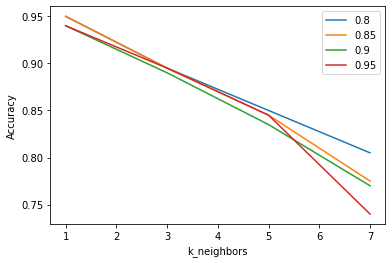

In [ ]:
idx=0
for proj_matrix in proj_matrices:
    scores=[]
    for n_neighbors in kn_neighbors:
        d_train_pca = np.dot(d_training, proj_matrix)
        d_test_pca = np.dot(d_testing, proj_matrix)
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(d_train_pca, y_training)
        labels_pred = knn.predict(d_test_pca)
        accuracy = metrics.accuracy_score(y_testing, labels_pred)
        scores.append(accuracy)

    print(f"Accuracies after {alphas[idx]} =\n", scores)
    plt.plot(kn_neighbors, scores, label=f'{alphas[idx]}')
    plt.xlabel("k_neighbors")
    plt.ylabel("Accuracy") 
    idx+=1
plt.legend()
plt.show()

### LDA Tuning

In [ ]:
accuracies = []
for n_neighbors in kn_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    # training , d_train_lda = data after projection & y_training = labels
    knn.fit(d_train_lda, y_training) 
    # predicting d_test_lda
    labels_pred = knn.predict(d_test_lda)
    # comparing the results of predicted label with the results from LDA
    accuracy = metrics.accuracy_score(y_testing, labels_pred)
    accuracies = np.append(accuracies,accuracy)
print("accuracies =",accuracies)

accuracies = [0.95  0.865 0.81  0.775]


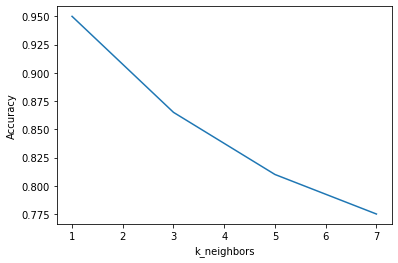

In [ ]:
plt.plot(kn_neighbors, accuracies)
plt.xlabel("k_neighbors")
plt.ylabel("Accuracy")
plt.show()

## 7. Compare vs Non-Face Images (15 Points)

In [ ]:
# !unzip non_faces.zip -d Animals-dataset

### Download non-face images and make them of the same size 92x112. and try to solve the classification problem faces vs. Non-faces.


In [ ]:
N = 10304
D_none = np.ones((1, N))

for i in range(1,401):
      path=f'Non-faces-dataset/non_faces/{i}.jpg'
      img = cv.imread(path, 0)
      temp_img = img[:92, :112]
      img = temp_img.T
      img = np.reshape(img, (1, N))  
      D_none = np.vstack((D_none,img))

# skip the first dummy row
D_none = D_none [1:]

print("D.shape =",D_none.shape)

D.shape = (400, 10304)


In [ ]:
Data = np.append(D, D_none, axis=0)
print(Data.shape)
face_label = np.ones((1,400))
non_face_label = np.zeros((1,400))
labels = np.append(face_label,non_face_label)
print(labels.shape)
print(labels)

####Dividing data into training and testing

In [ ]:
d2_training = Data[0::2, :]
d2_testing = Data[1::2, :]

print("d_training.shape =",d2_training.shape)
print("d_testing.shape =",d2_testing.shape)


d_training.shape = (400, 10304)
d_testing.shape = (400, 10304)


####Spliting Labels

In [ ]:
y2_training = labels[0::2]
y2_testing = labels[1::2]

y2_training = np.ndarray.tolist(y2_training)
y2_testing = np.ndarray.tolist(y2_testing)

print("y_training.shape =",len(y2_training))
print("y_testing.shape =",len(y2_testing))

y_training.shape = 400
y_testing.shape = 400


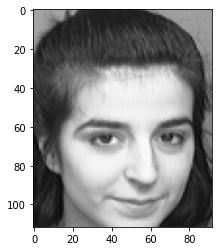

In [ ]:
img = d2_training[48]
img = np.reshape(img, (112,92))

plt.imshow(img, cmap='gray')
plt.show()

### PCA for non-facial images

In [ ]:
mean_none = np.mean(d2_training,axis=0)

# cenetered data
Z = d2_training - mean_none

cov_matrix_none = np.cov(Z.T,bias=True)
print(cov_matrix_none)

# cov_matrix = np.matmul(np.transpose(Z),Z)/(Z.shape[0])
# print(cov_matrix)

print("cov_matrix.shape =",cov_matrix_none.shape)



[[3266.9819     3221.232525   3130.08375    ...  352.583725
   450.190075    500.85555   ]
 [3221.232525   3269.46299375 3184.0090625  ...  410.76419375
   501.84398125  557.5464875 ]
 [3130.08375    3184.0090625  3172.054375   ...  415.7565625
   484.2496875   534.320625  ]
 ...
 [ 352.583725    410.76419375  415.7565625  ... 3258.87799375
  3143.14758125 3024.0728875 ]
 [ 450.190075    501.84398125  484.2496875  ... 3143.14758125
  3287.54694375 3159.9219625 ]
 [ 500.85555     557.5464875   534.320625   ... 3024.0728875
  3159.9219625  3297.733975  ]]
cov_matrix.shape = (10304, 10304)


In [ ]:
eigen_values,eigen_vectors=np.linalg.eigh(cov_matrix_none)
idx = np.argsort(eigen_values)[::-1]
eigen_values = eigen_values[idx]
eigen_vectors = eigen_vectors[:,idx]

Project new dataset of non-faces on the dominant eigen values based on alpha

In [ ]:
alphas = [0.8,0.85,0.9,0.95]
proj_matrices = []
sum_eigen_values=np.sum(eigen_values)
print("sum_eigen_values =",sum_eigen_values)
indexes = np.array([])

for alpha in alphas:
    accumulated_eigen_values=0
    explained_variance=0
    idx = 0 
    while explained_variance < alpha:
        accumulated_eigen_values +=eigen_values[idx]
        explained_variance = accumulated_eigen_values/float(sum_eigen_values)
        idx+=1
        #print(explained_variance)
    indexes=np.append(indexes,idx)
print(indexes)


for index in indexes:
     proj_matrix = eigen_vectors[:, :int(index)]
     proj_matrices.append(proj_matrix)

sum_eigen_values = 33254938.494443715
[ 25.  41.  70. 135.]


In [ ]:
scores = []

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(d2_training, y2_training)
labels_pred = knn.predict(d2_testing)
accuracy = metrics.accuracy_score(y2_testing, labels_pred)

print("Accuracy before projection =\n",accuracy)

Accuracy before projection =
 0.955


#### i. Show failure and success cases.

In [ ]:
for proj_matrix in proj_matrices:
    d_train_pca = np.dot(d2_training, proj_matrix)
    d_test_pca = np.dot(d2_testing, proj_matrix)
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(d_train_pca, y2_training)
    labels_pred = knn.predict(d_test_pca)
    accuracy = metrics.accuracy_score(y2_testing, labels_pred)
    scores.append(accuracy)

print("Accuracies after alpha =\n", scores)

Accuracies after alpha =
 [0.9475, 0.955, 0.9575, 0.9575]


### LDA for non-facial images


In [ ]:
overall_mean = np.mean(d2_training, axis = 0, keepdims=True)
print("overall_mean =\n", overall_mean)
print("overall_mean.shape =", overall_mean.shape,"\n")

print("d_training.shape =",d2_training.shape)

# Calculate the mean vector for every class Mu1, Mu2, ..., Mu40.
d_classes = np.array_split(d2_training, 2) # to split into 40 persons
d_classes = np.array(d_classes) 
print("d_classes.shape =",d_classes.shape)

mean_classes =  np.mean(d_classes,axis=1)  # to get the mean vector for each class
print("mean_classes.shape =",mean_classes.shape,"\n") 
# print("mean_classes=\n",mean_classes)

m,nk,N = d_classes.shape
print(f'm = {m}, nk = {nk} , N = {N} ')


overall_mean =
 [[103.09   103.7775 103.625  ...  99.0975  99.3325  99.355 ]]
overall_mean.shape = (1, 10304) 

d_training.shape = (400, 10304)
d_classes.shape = (2, 200, 10304)
mean_classes.shape = (2, 10304) 

m = 2, nk = 200 , N = 10304 


In [ ]:
# Sb stands for between-class scatter matrix (B in 2 dimensional sets)
Sb = np.zeros((N,N))

for k in range(0,m):
    # print(mean_classes[k])
    mean_diff = mean_classes[k]-overall_mean
    mean_diff = mean_diff.reshape(N, 1)
    # print("mean_diff =",mean_diff)
    Sb += nk * np.matmul(mean_diff,mean_diff.T)
print("Sb=\n", Sb)
print("Sb.shape =", Sb.shape)

Sb=
 [[115260.25   118909.875  115022.6    ... 153437.025  148955.625
  151213.3   ]
 [118909.875  122675.0625 118664.7    ... 158295.4875 153672.1875
  156001.35  ]
 [115022.6    118664.7    114785.44   ... 153120.66   148648.5
  150901.52  ]
 ...
 [153437.025  158295.4875 153120.66   ... 204258.8025 198293.0625
  201298.53  ]
 [148955.625  153672.1875 148648.5    ... 198293.0625 192501.5625
  195419.25  ]
 [151213.3    156001.35   150901.52   ... 201298.53   195419.25
  198381.16  ]]
Sb.shape = (10304, 10304)


In [ ]:
S=np.zeros((N,N))
for k in range(0,m):
    # center class matrices
    Z = d_classes[k]-mean_classes[k]
    S += np.matmul(Z.T,Z)
print("S=\n",S)
print("S.shape =",S.shape)

S=
 [[1191532.51  1169583.135 1137010.9   ...  -12403.535   31120.405
    49128.92 ]
 [1169583.135 1185110.135 1154938.925 ...    6010.19    47065.405
    67017.245]
 [1137010.9   1154938.925 1154036.31  ...   13181.965   45051.375
    62826.73 ]
 ...
 [ -12403.535    6010.19    13181.965 ... 1099292.395 1058965.97
  1008330.625]
 [  31120.405   47065.405   45051.375 ... 1058965.97  1122517.215
  1068549.535]
 [  49128.92    67017.245   62826.73  ... 1008330.625 1068549.535
  1120712.43 ]]
S.shape = (10304, 10304)


In [ ]:
S_inv = np.linalg.inv(S)
S_inv_B = np.dot(S_inv, Sb) 

eigen_values,eigen_vectors = np.linalg.eigh(S_inv_B)

# sorting descendingly according to highest eigen value 
idx = np.argsort(eigen_values)[::-1]
eigen_values = eigen_values[idx]
eigen_vectors = eigen_vectors[:,idx]

print("eigen_values.shape =",eigen_values.shape)
print("eigen_vectors.shape =",eigen_vectors.shape)


eigen_values.shape = (10304,)
eigen_vectors.shape = (10304, 10304)


#### ii. How many dominant eigenvectors will you use for the LDA solution?


In [ ]:
U = eigen_vectors[:,:40]
print("U.shape =", U.shape)

d_train_lda = np.matmul(d2_training,U)
d_test_lda = np.matmul(d2_testing,U)

print("d_train_lda.shape =", d_train_lda.shape)
print("d_test_lda.shape =", d_test_lda.shape)

U.shape = (10304, 40)
d_train_lda.shape = (400, 40)
d_test_lda.shape = (400, 40)


In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(d_train_lda, y2_training)
labels_pred = knn.predict(d_test_lda)
accuracy = metrics.accuracy_score(y2_testing, labels_pred)
print("Accuracy =", accuracy)

Accuracy = 0.99


#### iii. Plot the accuracy vs the number of non-faces images while fixing the number of face images.


In [ ]:
N = 10304
D_none = np.ones((1, N))
NumberOfNonFaces = [200, 300 ,400, 500 ,600]


DataSets = []
labelSets = []
for i in range(1,601):
      path=f'Non-faces-dataset/non_faces/{i}.jpg'
      img = cv.imread(path, 0)
      temp_img = img[:92, :112]
      img = temp_img.T
      img = np.reshape(img, (1, N))  
      D_none = np.vstack((D_none,img))

          
  # skip the first dummy row
D_none = D_none [1:]

for Number in NumberOfNonFaces:
  Data = np.append(D, D_none[0:Number,:], axis=0)
  DataSets.append(Data)
  print(Data.shape)
  face_label = np.ones((1,400))
  non_face_label = np.zeros((1,Number))
  labels = np.append(face_label,non_face_label)
  labelSets.append(labels)
  print(labels.shape)


(600, 10304)
(600,)
(700, 10304)
(700,)
(800, 10304)
(800,)
(900, 10304)
(900,)
(1000, 10304)
(1000,)


In [ ]:
Dtraining = []
Dtesting = []
Ytraining = []
Ytesting = []
for dataSet in DataSets:
  temp = dataSet[0::2, :]
  print("Dtraining DataSet =\n", temp.shape)
  Dtraining.append(temp)
  temp = dataSet[1::2, :]
  print("Dtraining DataSet =\n", temp.shape)
  Dtesting.append(temp)

for labelSet in labelSets:
  temp = labelSet[0::2]
  print("Dtraining DataSet =\n", temp.shape)
  Ytraining.append(temp)
  temp = labelSet[1::2]
  print("Dtraining DataSet =\n", temp.shape)
  Ytesting.append(temp)



Dtraining DataSet =
 (300, 10304)
Dtraining DataSet =
 (300, 10304)
Dtraining DataSet =
 (350, 10304)
Dtraining DataSet =
 (350, 10304)
Dtraining DataSet =
 (400, 10304)
Dtraining DataSet =
 (400, 10304)
Dtraining DataSet =
 (450, 10304)
Dtraining DataSet =
 (450, 10304)
Dtraining DataSet =
 (500, 10304)
Dtraining DataSet =
 (500, 10304)
Dtraining DataSet =
 (300,)
Dtraining DataSet =
 (300,)
Dtraining DataSet =
 (350,)
Dtraining DataSet =
 (350,)
Dtraining DataSet =
 (400,)
Dtraining DataSet =
 (400,)
Dtraining DataSet =
 (450,)
Dtraining DataSet =
 (450,)
Dtraining DataSet =
 (500,)
Dtraining DataSet =
 (500,)


### PCA of 5 datasets

In [ ]:
alpha = 0.95
index = 0
scores = []
for i in range(5):
  d2_training = Dtraining[i]
  d2_testing = Dtesting[i]
  y2_training = Ytraining[i]
  y2_testing = Ytesting[i]

  mean_none = np.mean(d2_training,axis=0)
  # cenetered data

  Z = d2_training - mean_none
  cov_matrix_none = np.cov(Z.T,bias=True)
  eigen_values,eigen_vectors=np.linalg.eigh(cov_matrix_none)
  idx = np.argsort(eigen_values)[::-1]
  eigen_values = eigen_values[idx]
  eigen_vectors = eigen_vectors[:,idx]
  sum_eigen_values=np.sum(eigen_values)
  
  accumulated_eigen_values = 0
  explained_variance = 0
  idx = 0 
  while explained_variance < alpha:
      accumulated_eigen_values +=eigen_values[idx]
      explained_variance = accumulated_eigen_values/float(sum_eigen_values)
      idx+=1
      #print(explained_variance)
  index = idx
  proj_matrix = eigen_vectors[:, :int(index)]

  d_train_pca = np.dot(d2_training, proj_matrix)
  d_test_pca = np.dot(d2_testing, proj_matrix)
  knn = KNeighborsClassifier(n_neighbors=1)
  knn.fit(d_train_pca, y2_training)
  labels_pred = knn.predict(d_test_pca)
  accuracy = metrics.accuracy_score(y2_testing, labels_pred)
  scores.append(accuracy)

print(scores)


[0.9666666666666667, 0.9628571428571429, 0.9575, 0.9533333333333334, 0.958]


In [ ]:
pca_scores = scores
#[0.9666666666666667, 0.9628571428571429, 0.9575, 0.9533333333333334, 0.958]

### LDA of 5 datasets

In [ ]:
scores = []
for i in range(5):
  d2_training = Dtraining[i]
  d2_testing = Dtesting[i]
  y2_training = Ytraining[i]
  y2_testing = Ytesting[i]

  overall_mean = np.mean(d2_training, axis = 0, keepdims=True)
  d_classes = np.array_split(d2_training, 2) 
  d_classes = np.array(d_classes) 

  mean_classes =  np.mean(d_classes,axis=1)  
  m,nk,N = d_classes.shape
  
  Sb = np.zeros((N,N))

  for k in range(0,m):
    # print(mean_classes[k])
    mean_diff = mean_classes[k]-overall_mean
    mean_diff = mean_diff.reshape(N, 1)
    # print("mean_diff =",mean_diff)
    Sb += nk * np.matmul(mean_diff,mean_diff.T)
  S=np.zeros((N,N))
  for k in range(0,m):
    # center class matrices
    Z = d_classes[k]-mean_classes[k]
    S += np.matmul(Z.T,Z)

  S_inv = np.linalg.inv(S)
  S_inv_B = np.dot(S_inv, Sb) 

  eigen_values,eigen_vectors = np.linalg.eigh(S_inv_B)

  # sorting descendingly according to highest eigen value 
  idx = np.argsort(eigen_values)[::-1]
  eigen_values = eigen_values[idx]
  eigen_vectors = eigen_vectors[:,idx]

  U = eigen_vectors[:,:40]

  d_train_lda = np.matmul(d2_training,U)
  d_test_lda = np.matmul(d2_testing,U)

  knn = KNeighborsClassifier(n_neighbors=1)
  knn.fit(d_train_lda, y2_training)
  labels_pred = knn.predict(d_test_lda)
  accuracy = metrics.accuracy_score(y2_testing, labels_pred)
  scores.append(accuracy)
print(scores)

[0.9633333333333334]
[0.9633333333333334, 0.96]
[0.9633333333333334, 0.96, 0.955]
[0.9633333333333334, 0.96, 0.955, 0.9688888888888889]
[0.9633333333333334, 0.96, 0.955, 0.9688888888888889, 0.964]


In [ ]:
lda_scores = scores
#[0.9633333333333334, 0.96, 0.955, 0.9688888888888889, 0.964]

### The Plot

#### PCA plot

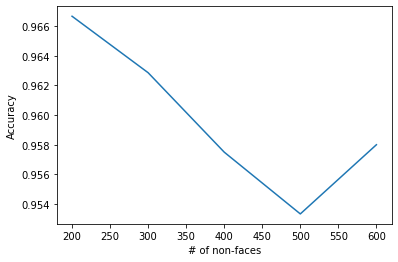

In [ ]:
x1 = NumberOfNonFaces
y1 = pca_scores
plt.plot(x1, y1)
plt.xlabel("# of non-faces")
plt.ylabel("Accuracy")
plt.show()

#### LDA Plot

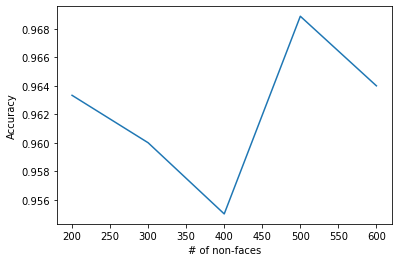

In [ ]:
x2 = NumberOfNonFaces
y2 = lda_scores
plt.plot(x2, y2)
plt.xlabel("# of non-faces")
plt.ylabel("Accuracy")
plt.show()

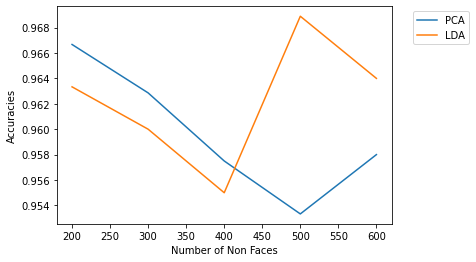

In [ ]:
plt.xlabel("Number of Non Faces")
plt.ylabel("Accuracies")
plt.plot(x1,y1, label="PCA")
plt.plot(x2,y2, label="LDA")

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.show()

#### iv. Criticize the accuracy measure for large numbers of non-faces images in the training data.

######The analysis

PCA has better accuracy than LDA, but there is a sudden increase then decrease in LDA accuracy when Number of non faces exceeds 400. At Number non faces 500 PCA increases slightily

Conclusion:
PCA performs better at low number of datasets but performs badly at big datasets while LDA is the opposite

## Bonus (5 Points)

### a. [5 points] Use different Training and Test splits. Change the number of instances per subject to be 7 and keep 3 instances per subject for testing. compare the results you have with the ones you got earlier with 50% split.


#### Loading Data

In [ ]:
N = 10304
D = np.ones((1, N))
y = []

for i in range(1,41):
    for j in range(1,11):
        # path = f'ORL-dataset/s{i}/{j}.pgm'
        path=f'drive/MyDrive/Colab-datasets/Assignment1/faces/s{i}/{j}.pgm'
        img = cv.imread(path, 0)
        img = np.reshape(img, (1, N))  
        D = np.vstack((D,img))
        y.append(i)

# skip the first dummy row
D = D [1:]

print("D.shape =",D.shape)

D.shape = (400, 10304)


#### Splitting

In [ ]:
indexes1 = np.arange(0,7)

for i in range(1,40):
    indexes1 =  np.append(indexes1, np.arange(0,7)+10*i)

indexes1.flatten()
print("indexes1.shape =",indexes1.shape )

indexes2 = np.arange(7,10)
for i in range(1,40):
    indexes2 =  np.append(indexes2, np.arange(7,10)+10*i)

indexes2.flatten()
print("indexes2.shape =",indexes2.shape )


indexes1.shape = (280,)
indexes2.shape = (120,)


In [ ]:
d_training = D[indexes1, :]
d_testing = D[indexes2, :]
print("d_training.shape =",d_training.shape)
print("d_testing.shape =",d_testing.shape)

d_training.shape = (280, 10304)
d_testing.shape = (120, 10304)


In [ ]:
y = np.array(y)
y_training = y[indexes1]
y_testing = y[indexes2]

print("y_training.shape =",len(y_training))
print("y_testing.shape =",len(y_testing))

y_training.shape = 280
y_testing.shape = 120


#### PCA

In [ ]:
# Loading the PCA algorithm
alphas = [0.8,0.85,0.9,0.95]
scores = []

for alpha in alphas:
    pca = PCA(n_components=alpha)
    pca.fit(d_training)
     
    ratio = np.sum(pca.explained_variance_ratio_)
    print("alpha = ",ratio)

    d_trained = pca.transform(d_training)
    d_tested = pca.transform(d_testing)


    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(d_trained, y_training)
    y_predicted = knn.predict(d_tested)
    accuracy = metrics.accuracy_score(y_testing, y_predicted)
    scores.append(accuracy)

print(scores)



alpha =  0.8029351586996791
alpha =  0.8501349006316229
alpha =  0.9005313438487145
alpha =  0.9501831528440492
[0.9583333333333334, 0.9666666666666667, 0.9666666666666667, 0.95]


#### LDA

In [ ]:
overall_mean = np.mean(d_training, axis = 0, keepdims=True)
print("overall_mean =\n", overall_mean)
print("overall_mean.shape =", overall_mean.shape,"\n")

print("d_training.shape =",d_training.shape)

# Calculate the mean vector for every class Mu1, Mu2, ..., Mu40.
d_classes = np.array_split(d_training, 40) # to split into 40 persons
d_classes = np.array(d_classes) 
print("d_classes.shape =",d_classes.shape)

mean_classes =  np.mean(d_classes,axis=1)  # to get the mean vector for each class
print("mean_classes.shape =",mean_classes.shape,"\n") 
# print("mean_classes=\n",mean_classes)

m,nk,N = d_classes.shape
print(f'm = {m}, nk = {nk} , N = {N} ')

# Sb stands for between-class scatter matrix (B in 2 dimensional sets)
Sb = np.zeros((N,N))

for k in range(0,m):
    # print(mean_classes[k])
    mean_diff = mean_classes[k]-overall_mean
    mean_diff = mean_diff.reshape(N, 1)
    # print("mean_diff =",mean_diff)
    Sb += nk * np.matmul(mean_diff,mean_diff.T)
# print("Sb=\n", Sb)
print("Sb.shape =", Sb.shape)

S=np.zeros((N,N))
for k in range(0,m):
    # center class matrices
    Z = d_classes[k]-mean_classes[k]
    S += np.matmul(Z.T,Z)
# print("S=\n",S)
print("S.shape =",S.shape)

S_inv = np.linalg.inv(S)
S_inv_B = np.dot(S_inv, Sb) 

eigen_values,eigen_vectors = np.linalg.eigh(S_inv_B)

# sorting descendingly according to highest eigen value 
idx = np.argsort(eigen_values)[::-1]
eigen_values = eigen_values[idx]
eigen_vectors = eigen_vectors[:,idx]

print("eigen_values.shape =",eigen_values.shape)
print("eigen_vectors.shape =",eigen_vectors.shape)

U = eigen_vectors[:,:40]
print("U.shape =", U.shape)

d_train_lda = np.matmul(d_training,U)
d_test_lda = np.matmul(d_testing,U)

print("d_train_lda.shape =", d_train_lda.shape)
print("d_test_lda.shape =", d_test_lda.shape)

overall_mean =
 [[85.41071429 85.33928571 85.65357143 ... 74.75714286 74.16785714
  73.35714286]]
overall_mean.shape = (1, 10304) 

d_training.shape = (280, 10304)
d_classes.shape = (40, 7, 10304)
mean_classes.shape = (40, 10304) 

m = 40, nk = 7 , N = 10304 
Sb.shape = (10304, 10304)
S.shape = (10304, 10304)
eigen_values.shape = (10304,)
eigen_vectors.shape = (10304, 10304)
U.shape = (10304, 40)
d_train_lda.shape = (280, 40)
d_test_lda.shape = (120, 40)


In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(d_train_lda, y_training)
labels_pred = knn.predict(d_test_lda)

accuracy = metrics.accuracy_score(y_testing, labels_pred)
print("Accuracy =", accuracy)

Accuracy = 0.9416666666666667


In [ ]:
# using sklearn LDA
print("d_training.shape =",d_training.shape)
print("d_testing.shape =",d_testing.shape)

lda = LinearDiscriminantAnalysis()
lda.fit(d_training, y_training)

d_trained = lda.transform(d_training)
d_tested = lda.transform(d_testing)



knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(d_trained, y_training)
y_predicted = knn.predict(d_tested)
print("accuracy =",metrics.accuracy_score(y_testing, y_predicted))

d_training.shape = (280, 10304)
d_testing.shape = (120, 10304)
accuracy = 0.95


### b. [10 points] There are other variations of PCA and LDA beyond the original algorithms. Please use one of the variations of PCA and one variations of LDA other than the original ones. Compare the time complexity and accuracy between the 2 different PCA and LDA models.

In [ ]:
n_components = 55
n_neighbors = 4
scores = []

In [ ]:
# d_training, d_testing, y_training, y_testing = train_test_split(D, y, test_size=0.6)

In [ ]:
d_training = D[0::2, :]
d_testing = D[1::2, :]
print("d_training.shape =",d_training.shape)
print("d_testing.shape =",d_testing.shape)

y_training = y[0::2]
y_testing = y[1::2]

print("y_training.shape =",len(y_training))
print("y_testing.shape =",len(y_testing))

d_training.shape = (200, 10304)
d_testing.shape = (200, 10304)
y_training.shape = 200
y_testing.shape = 200


#### PCA Variations

##### PCA

In [ ]:

pca = PCA(n_components=n_components)
pca.fit(d_training)

ratio = np.sum(pca.explained_variance_ratio_)

d_trained = pca.transform(d_training)
d_tested = pca.transform(d_testing)


knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(d_trained, y_training)
y_predicted = knn.predict(d_tested)
accuracy = metrics.accuracy_score(y_testing, y_predicted)
print(accuracy)
scores.append(accuracy)

0.865


##### KernelPCA


In [ ]:

pca = KernelPCA(n_components=n_components, kernel='poly')
pca.fit(d_training)

d_trained = pca.transform(d_training)
d_tested = pca.transform(d_testing)


knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(d_trained, y_training)
y_predicted = knn.predict(d_tested)
accuracy = metrics.accuracy_score(y_testing, y_predicted)
print(accuracy)
scores.append(accuracy)

0.875


##### IncrementalPCA

In [ ]:

pca = IncrementalPCA(n_components=n_components)

pca.partial_fit(d_training)

d_trained = pca.transform(d_training)
d_tested = pca.transform(d_testing)


knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(d_trained, y_training)
y_predicted = knn.predict(d_tested)
accuracy = metrics.accuracy_score(y_testing, y_predicted)
print(accuracy)
scores.append(accuracy)

0.875


#### LDA Variations

In [ ]:
scores = []

###### LDA

In [ ]:
print("d_training.shape =",d_training.shape)
print("d_testing.shape =",d_testing.shape)

lda = LinearDiscriminantAnalysis()
lda.fit(d_training, y_training)

d_trained = lda.transform(d_training)
d_tested = lda.transform(d_testing)



knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(d_trained, y_training)
y_predicted = knn.predict(d_tested)
print("accuracy =",metrics.accuracy_score(y_testing, y_predicted))

d_training.shape = (200, 10304)
d_testing.shape = (200, 10304)
accuracy = 0.93


###### RDA Regularized Discriminant Analysis

In [ ]:
rda = LinearDiscriminantAnalysis(solver='lsqr',shrinkage='auto')
rda.fit(d_training, y_training)

LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')

In [ ]:

y_predicted = rda.predict(d_testing)

accuracy = np.mean(y_predicted == y_testing)
print('accuracy =', accuracy)

accuracy = 0.97


###### QDA

In [ ]:
# d_training, d_testing, y_training, y_testing = train_test_split(D, y, test_size=0.3)

In [ ]:
qda = QuadraticDiscriminantAnalysis()
# print("d_training=\n",d_training)
# print("y_training=\n",y_training)
qda.fit(d_training, y_training)

y_predicted = qda.predict(d_testing) 

# print("y_testing=\n",y_testing)
# print("y_predicted=\n",y_predicted)

print("accuracy =",metrics.accuracy_score(y_testing, y_predicted))
scores.append(accuracy)

/usr/local/lib/python3.9/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


accuracy = 0.05


In [ ]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(d_training, y_training)

# Use the QDA model to predict the labels of the testing data
y_predicted = qda.predict(d_testing)

# Compute the accuracy of the QDA model
accuracy = np.mean(y_predicted == y_testing)
print('accuracy =', accuracy)

/usr/local/lib/python3.9/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


accuracy = 0.05
